In [1]:
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set the country code
country_code = ['AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'COL', 'CRI',
                'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU',
                'GRC', 'HUN', 'ISL', 'IRL', 'ISR', 'ITA', 'JPN', 
                'KOR', 'LVA', 'LTU', 'LUX', 'MEX', 'NLD', 'NZL', 'NOR',
                 'POL', 'PRT', 'SVK', 'SVN', 'ESP', 'SWE',
                'CHE', 'TUR', 'GBR', 'USA']

# Set the indicators
indicators = {
    'BX.KLT.DINV.WD.GD.ZS': 'FDI_NET',
    'NE.TRD.GNFS.ZS': 'TradeOpen',
    'NY.GDP.PCAP.CD': 'GDP_per_capita',
    'FP.CPI.TOTL.ZG': 'CPI_Inflation_rate',
    #'SP.POP.GROW': 'Pop_growth',
    'NE.CON.GOVT.ZS': 'GOVT_EXP'
}

# Get the data
data = wbdata.get_dataframe(indicators, country=country_code, convert_date=True)

# Reorder the rows with 1960 as the first index
data = data.reindex(index=data.index[::-1])

# Sort the data by country and year
data = data.sort_index(level=['country', 'date'])

# Slice the data to only include years 1990 to 2019
idx = pd.IndexSlice
data = data.loc[idx[:, '1990-01-01':'2019-01-01'], :]

In [3]:
data

FDI_NET  TradeOpen  GDP_per_capita   
country       date                                              
Australia     1990-01-01  2.715756  32.152317    18249.709485  \
              1991-01-01  0.801279  32.188568    18860.581591   
              1992-01-01  1.518103  33.043854    18624.555084   
              1993-01-01  1.701950  35.399057    17700.115556   
              1994-01-01  1.381151  36.458496    18129.790720   
...                            ...        ...             ...   
United States 2015-01-01  2.809148  27.812234    56762.729452   
              2016-01-01  2.537498  26.586999    57866.744934   
              2017-01-01  1.955211  27.279161    59907.754261   
              2018-01-01  1.045704  27.610379    62823.309438   
              2019-01-01  1.472075  26.451949    65120.394663   

                          CPI_Inflation_rate   GOVT_EXP  
country       date                                       
Australia     1990-01-01            7.333022  17.641361  
              1991-01-01            3.176675  18.631483  
              1992-01-01            1.012231  19.495664  
              1993-01-01            1.753653  19.375781  
              1994-01-01            1.969635  18.812698  
...                                      ...        ...  
United States 2015-01-01            0.118627  14.330331  
              2016-01-01            1.261583  14.244944  
              2017-01-01            2.130110  13.998629  
              2018-01-01            2.442583  13.962519  
              2019-01-01            1.812210  14.072225  

[1140 rows x 5 columns]

In [4]:
data.isna().sum()

FDI_NET               44
TradeOpen             31
GDP_per_capita        26
CPI_Inflation_rate    11
GOVT_EXP              31
dtype: int64

#### Taking log of the columns to level the dataset

In [5]:
for col in data.columns:
    new_col = 'log_' + col
    data[new_col] = data[col].apply(np.log)

In [6]:
data = data.loc[:, data.columns.str.contains('log')]

In [7]:
data = data.groupby('country').apply(lambda x: x.dropna())

In [8]:
# Reset the index and drop the first level
data = data.reset_index(level=0, drop=True)

In [9]:
data

log_FDI_NET  log_TradeOpen  log_GDP_per_capita   
country       date                                                         
Australia     1990-01-01     0.999070       3.470485            9.811904  \
              1991-01-01    -0.221546       3.471611            9.844829   
              1992-01-01     0.417461       3.497836            9.832236   
              1993-01-01     0.531775       3.566685            9.781326   
              1994-01-01     0.322917       3.596175            9.805312   
...                               ...            ...                 ...   
United States 2015-01-01     1.032881       3.325476           10.946635   
              2016-01-01     0.931178       3.280422           10.965898   
              2017-01-01     0.670498       3.306123           11.000561   
              2018-01-01     0.044690       3.318192           11.048081   
              2019-01-01     0.386673       3.275330           11.083993   

                          log_CPI_Inflation_rate  log_GOVT_EXP  
country       date                                              
Australia     1990-01-01                1.992388      2.870246  
              1991-01-01                1.155835      2.924853  
              1992-01-01                0.012157      2.970192  
              1993-01-01                0.561701      2.964024  
              1994-01-01                0.677848      2.934532  
...                                          ...           ...  
United States 2015-01-01               -2.131770      2.662378  
              2016-01-01                0.232367      2.656402  
              2017-01-01                0.756174      2.638959  
              2018-01-01                0.893056      2.636377  
              2019-01-01                0.594547      2.644203  

[965 rows x 5 columns]

### Descriptive statistics

In [10]:
data.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
log_FDI_NET,965.0,0.909,1.237,-6.524,0.318,0.975,1.581,4.460
log_TradeOpen,965.0,4.272,0.501,2.761,3.969,4.238,4.595,5.934
log_GDP_per_capita,965.0,9.868,0.890,7.291,9.349,10.047,10.558,11.725
log_CPI_Inflation_rate,965.0,0.999,1.099,-4.791,0.479,0.945,1.532,4.656
log_GOVT_EXP,965.0,2.893,0.238,2.094,2.777,2.938,3.049,3.336


In [11]:
skewness = data.skew()
skewness

log_FDI_NET              -0.865662
log_TradeOpen             0.140460
log_GDP_per_capita       -0.623778
log_CPI_Inflation_rate   -0.220232
log_GOVT_EXP             -0.839800
dtype: float64

In [12]:
kurtosis = data.kurt()
kurtosis

log_FDI_NET               4.058069
log_TradeOpen             0.410903
log_GDP_per_capita       -0.232433
log_CPI_Inflation_rate    2.404744
log_GOVT_EXP              0.294280
dtype: float64

In [13]:
corr = data.corr()
corr

,log_FDI_NET,log_TradeOpen,log_GDP_per_capita,log_CPI_Inflation_rate,log_GOVT_EXP
log_FDI_NET,1.000000,0.510135,0.050299,-0.069367,0.086277
log_TradeOpen,0.510135,1.000000,0.163938,-0.179142,0.225304
log_GDP_per_capita,0.050299,0.163938,1.000000,-0.618836,0.343730
log_CPI_Inflation_rate,-0.069367,-0.179142,-0.618836,1.000000,-0.262824
log_GOVT_EXP,0.086277,0.225304,0.343730,-0.262824,1.000000


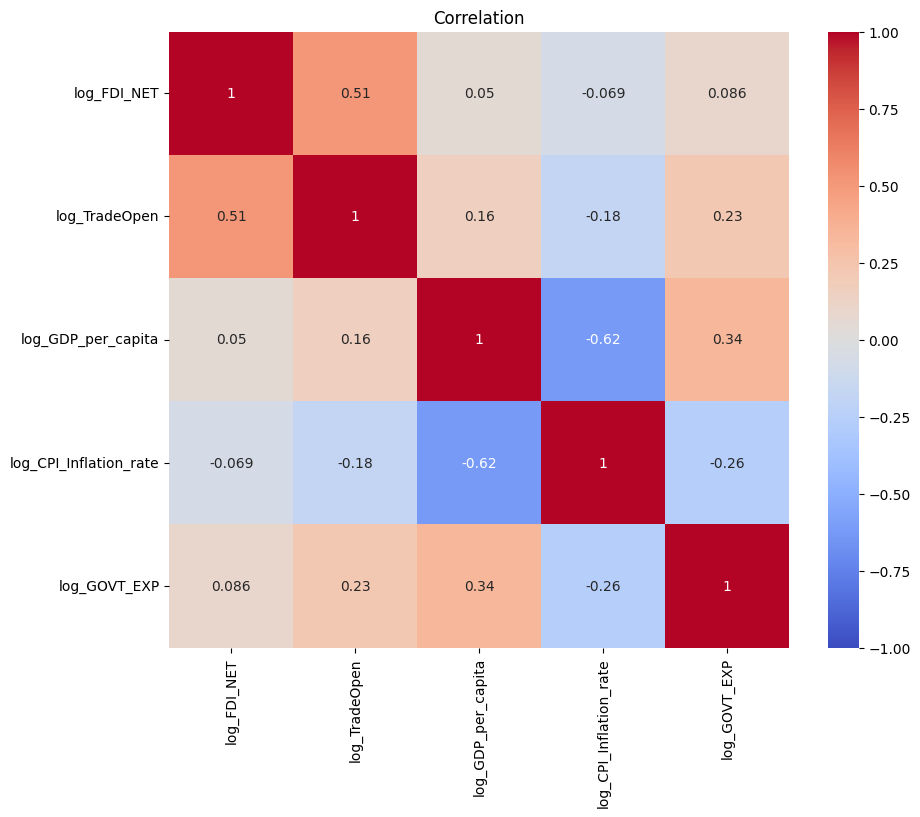

In [14]:
fig, ax = plt.subplots(figsize = (10, 8))

# create a heatmap using seaborn
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax =ax)

# set rotation for x-axis and y-axis tick labels
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

# set plot title
plt.title('Correlation')

# show the plot
plt.show()

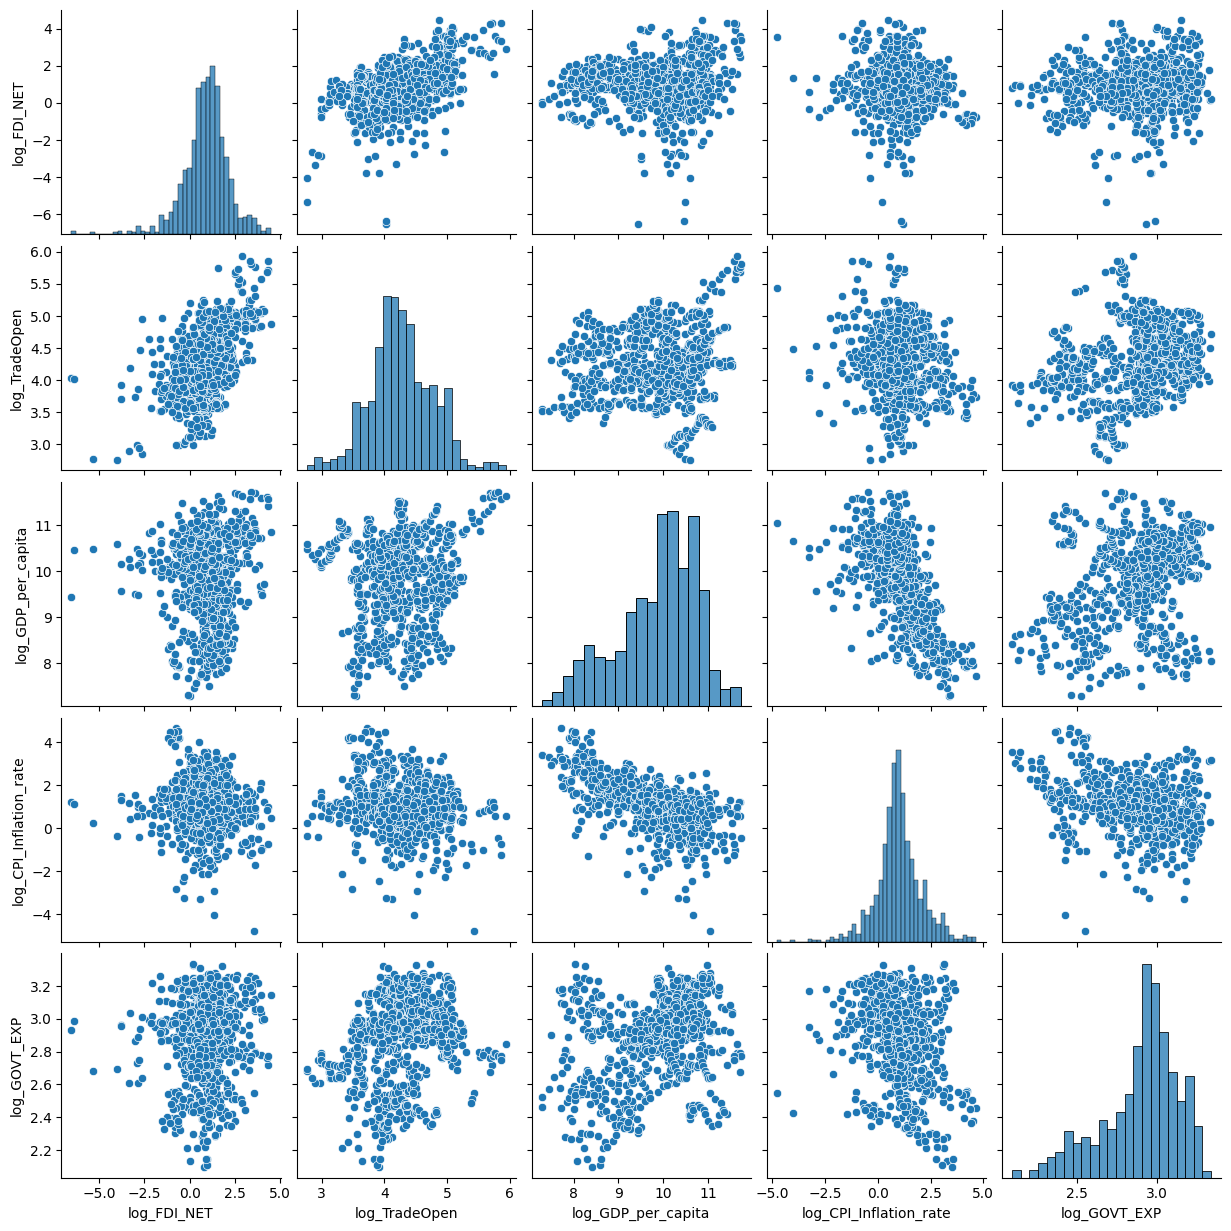

In [15]:
# Set the hue parameter to the country column
sns.pairplot(data)


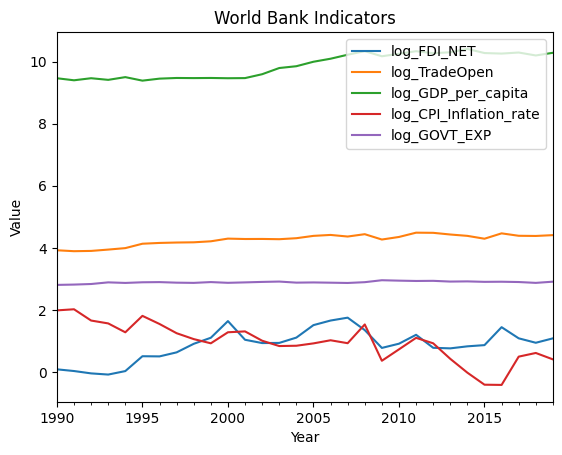

In [16]:
import matplotlib.pyplot as plt

# Plot the data
ax = data.groupby(level='date').mean().plot()

# Set the title and axis labels
ax.set_title('World Bank Indicators')
ax.set_xlabel('Year')
ax.set_ylabel('Value')

# Show the plot
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    
    
    adf_result = adfuller(timeseries)
    adf_stat, pvalue, lags, _, _, _ = adf_result
    
    if pvalue < 0.05:
        print(f"The ADF test result indicates that the time series is stationary (p-value: {pvalue:.4f})")
    else:
        print(f"The ADF test result indicates that the time series is non-stationary (p-value: {pvalue:.4f})")
        
    return adf_stat, pvalue, lags
        
adf_test(data['log_TradeOpen'])

The ADF test result indicates that the time series is stationary (p-value: 0.0000)


(-5.438144119828117, 2.8152681863461413e-06, 1)

In [18]:
adf_test(data['log_CPI_Inflation_rate'])

The ADF test result indicates that the time series is stationary (p-value: 0.0000)


(-11.661428581341909, 1.9292009989276625e-21, 1)

In [19]:
adf_test(data['log_GOVT_EXP'])

The ADF test result indicates that the time series is stationary (p-value: 0.0000)


(-5.248893179412458, 6.980926409060935e-06, 0)

In [20]:
adf_test(data['log_GDP_per_capita'])

The ADF test result indicates that the time series is stationary (p-value: 0.0000)


(-5.875476437453546, 3.1670151191038143e-07, 0)

In [21]:
adf_test(data['log_FDI_NET'])

The ADF test result indicates that the time series is stationary (p-value: 0.0000)


(-8.341885819497659, 3.1599027426522285e-13, 3)

In [22]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm


exog_vars = ['log_FDI_NET', 'log_CPI_Inflation_rate', 'log_TradeOpen', 'log_GOVT_EXP']
exog = sm.add_constant(data[exog_vars])
endog = data['log_GDP_per_capita']

# Fit a fixed effects model
mod = PanelOLS(endog, exog, entity_effects=True, time_effects=False)
res_fe = mod.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:     log_GDP_per_capita   R-squared:                        0.4395
Estimator:                   PanelOLS   R-squared (Between):             -0.3119
No. Observations:                 965   R-squared (Within):               0.4395
Date:                Tue, May 09 2023   R-squared (Overall):             -0.0959
Time:                        06:33:44   Log-likelihood                   -306.97
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      180.95
Entities:                          38   P-value                           0.0000
Avg Obs:                       25.395   Distribution:                   F(4,923)
Min Obs:                       15.000                                           
Max Obs:                       30.000   F-statistic (robust):             41.203
                            

In [23]:
data['Predicted GDP_per_capita'] = res_fe.predict()
data['Residuals'] = res_fe.resids

In [24]:
data

log_FDI_NET  log_TradeOpen  log_GDP_per_capita   
country       date                                                         
Australia     1990-01-01     0.999070       3.470485            9.811904  \
              1991-01-01    -0.221546       3.471611            9.844829   
              1992-01-01     0.417461       3.497836            9.832236   
              1993-01-01     0.531775       3.566685            9.781326   
              1994-01-01     0.322917       3.596175            9.805312   
...                               ...            ...                 ...   
United States 2015-01-01     1.032881       3.325476           10.946635   
              2016-01-01     0.931178       3.280422           10.965898   
              2017-01-01     0.670498       3.306123           11.000561   
              2018-01-01     0.044690       3.318192           11.048081   
              2019-01-01     0.386673       3.275330           11.083993   

                          log_CPI_Inflation_rate  log_GOVT_EXP   
country       date                                               
Australia     1990-01-01                1.992388      2.870246  \
              1991-01-01                1.155835      2.924853   
              1992-01-01                0.012157      2.970192   
              1993-01-01                0.561701      2.964024   
              1994-01-01                0.677848      2.934532   
...                                          ...           ...   
United States 2015-01-01               -2.131770      2.662378   
              2016-01-01                0.232367      2.656402   
              2017-01-01                0.756174      2.638959   
              2018-01-01                0.893056      2.636377   
              2019-01-01                0.594547      2.644203   

                          Predicted GDP_per_capita  Residuals  
country       date                                             
Australia     1990-01-01                  8.779660  -0.153883  
              1991-01-01                  8.876068  -0.217366  
              1992-01-01                  9.087668  -0.441559  
              1993-01-01                  9.096770  -0.501571  
              1994-01-01                  9.104047  -0.484862  
...                                            ...        ...  
United States 2015-01-01                  9.115236  -0.194370  
              2016-01-01                  8.739488   0.200641  
              2017-01-01                  8.688899   0.285894  
              2018-01-01                  8.668632   0.353681  
              2019-01-01                  8.668292   0.389932  

[965 rows x 7 columns]

<Axes: xlabel='date'>

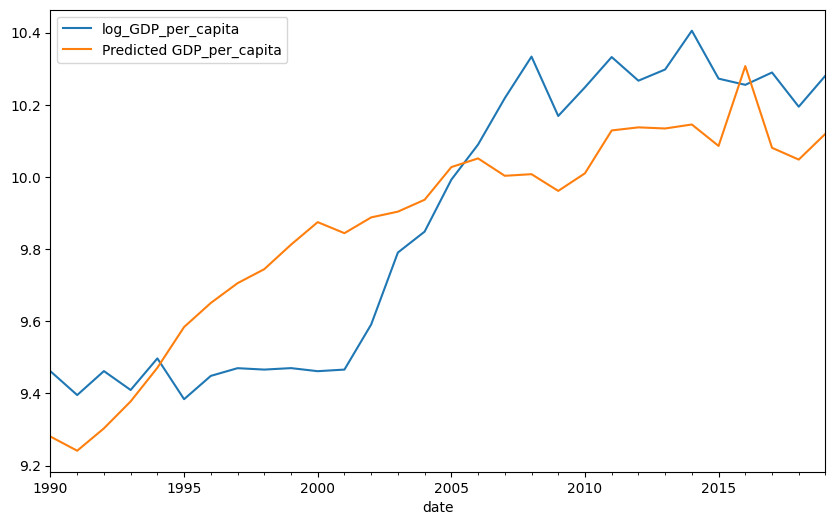

In [25]:
fig, ax = plt.subplots(figsize = (10, 6))

data[['log_GDP_per_capita', 'Predicted GDP_per_capita']].groupby(level='date').mean().plot(ax = ax)


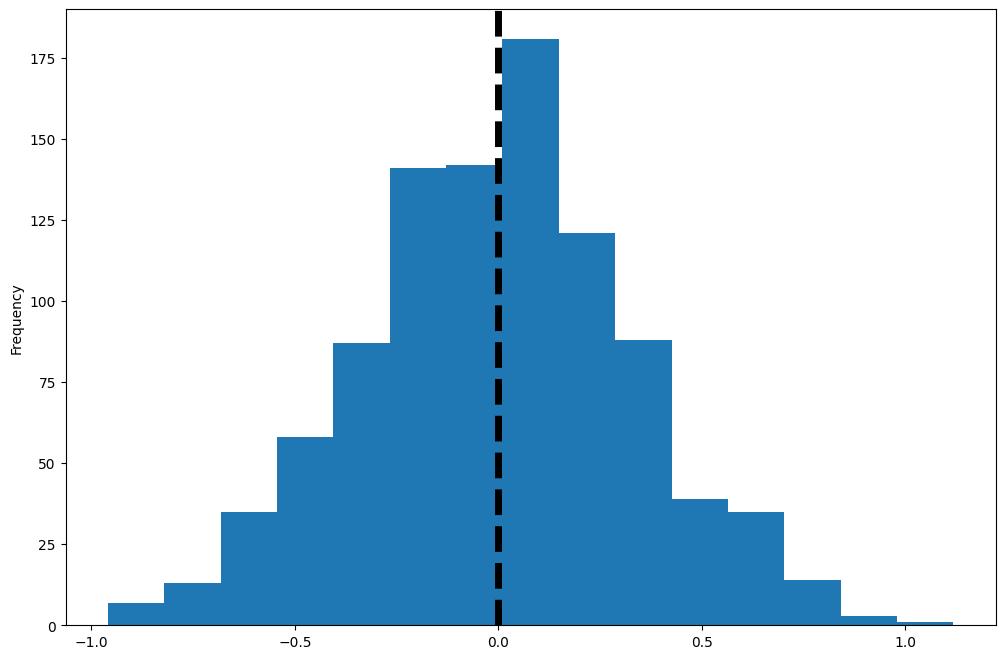

In [26]:
# plot histogram of residuals
fig, ax = plt.subplots(figsize = (12, 8))
data['Residuals'].plot.hist(bins = 15, ax = ax)

# plot vertical line for mean of residuals
ax.axvline(data['Residuals'].mean(), ls = '--', linewidth = 5, color = 'k')